# Online Multiclass Logistic Regression using CMGF

##0. Imports

In [1]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging, sys, warnings, os

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

# if not sys.warnoptions:
#     warnings.simplefilter("ignore")
#     os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [2]:
try:
    from dynamax.generalized_gaussian_ssm.inference import *
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq dynamax
    from dynamax.generalized_gaussian_ssm.inference import *

In [3]:
from warnings import simplefilter

import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.random as jr
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

## 1. CMGF Model for Online Multiclass Logistic Regression

Note that the moments of a (one-hot-encoded) categorical distribution with $K$ possible classes are as follows:

$$\mathbb{E}[\vec{y}|\vec{x}, \textbf{W}] =  \begin{pmatrix} \sigma_2(\textbf{W}^T\vec{x}) \\ \sigma_3(\textbf{W}^T\vec{x}) \\ \vdots \\ \sigma_K(\textbf{W}^T\vec{x}) \end{pmatrix}
$$
$$Cov[\vec{y}|\vec{x}, \textbf{W}] = \begin{pmatrix} p_2 (1 - p_2) & -p_2 p_3 & \dots & -p_2 p_K \\
-p_2 p_3 & p_3 (1 - p_3) & \dots  & -p_3 p_K \\
\vdots & \vdots & \ddots & \vdots \\
-p_2 p_K & -p_3 p_K & \dots & p_K (1 - p_K)
 \end{pmatrix}$$
where $\vec{\sigma}(\cdot)$ is the softmax function.

Note that in order to prevent the "Dummy Variable Trap," we drop the first column.

Thus, we can build a generic multiclass CMGF classifier that works with the `scikit-learn` cross validation tool as follows.



In [4]:
from dynamax.generalized_gaussian_ssm.demos.cmgf_logreg_estimator import CMGFEstimator

In [5]:
CMGFEstimator??

Init signature: CMGFEstimator(mean=None, cov=None)
Docstring:     
Base class for all estimators in scikit-learn.

Notes
-----
All estimators should specify all the parameters that can be set
at the class level in their ``__init__`` as explicit keyword
arguments (no ``*args`` or ``**kwargs``).
Source:        
class CMGFEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self,  mean=None, cov=None):
        self.mean = mean
        self.cov = cov

    def fit(self, X, y):
        X_bias = jnp.concatenate([jnp.ones((len(X), 1)), X], axis=1)
        # Encode output as one-hot-encoded vectors with first column dropped,
        # i.e., [0, ..., 0] correspondes to 1st class
        # This is done to prevent the "Dummy Variable Trap".
        enc = OneHotEncoder(drop='first')
        y_oh = jnp.array(enc.fit_transform(y.reshape(-1, 1)).toarray())
        input_dim = X_bias.shape[-1]
        num_classes = y_oh.shape[-1] + 1
        self.classes_ = jnp.arange(num_classes)
        weight

##2. Accuracy Comparison with SGD

We compare classification accuracy of CMGF with those of one-pass SGD and multi-pass SGD using 10-fold cross validation.

In [6]:
def compute_cv_avg_score(estimator, num_points, num_classes, n_splits=10, scoring='accuracy'):
    # Generate dataset
    X, y = make_classification(n_samples=num_points, n_features=num_classes+1, 
                               n_informative=num_classes+1, n_redundant=0, n_classes=num_classes, random_state=0)
    
    # Set up pipeline to avoid fitting scaler to test dataset
    scaler = preprocessing.StandardScaler()
    pipeline = Pipeline([('transformer', scaler), ('estimator', estimator)])

    # K-fold cross validationaccuracy
    cv = KFold(n_splits=n_splits)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)

    return scores.mean()

In [7]:
num_points = 1000
class_range = range(2, 19)
n_splits = 10

cmgf_accuracies, sgd_onepass_accuracies, sgd_multipass_accuracies = [], [], []
simplefilter("ignore", category=ConvergenceWarning)
for num_classes in class_range:
    print(f'{num_points} data points, {num_classes} classes.')
    
    # Initialize estimators
    cmgf_est = CMGFEstimator()
    sgd_op_est = SGDClassifier(loss='log_loss', max_iter=1)
    sgd_mp_est = SGDClassifier(loss='log_loss')
    
    # Compute cv average scores
    cmgf_ac = compute_cv_avg_score(cmgf_est, num_points, num_classes, n_splits=n_splits)
    cmgf_accuracies.append(cmgf_ac)
    print(f'EKF-CMGF estimate average accuracy = {cmgf_ac}')
    sgd_op_ac = compute_cv_avg_score(sgd_op_est, num_points, num_classes, n_splits=n_splits)
    sgd_onepass_accuracies.append(sgd_op_ac)
    print(f'One-pass sgd estimate average accuracy = {sgd_op_ac}')
    sgd_mp_ac = compute_cv_avg_score(sgd_mp_est, num_points, num_classes, n_splits=n_splits)
    sgd_multipass_accuracies.append(sgd_mp_ac)
    print(f'Multi-pass sgd estimate average accuracy = {sgd_mp_ac}')
    

1000 data points, 2 classes.
EKF-CMGF estimate average accuracy = 0.7219999999999999
One-pass sgd estimate average accuracy = 0.6729999999999999
Multi-pass sgd estimate average accuracy = 0.72
1000 data points, 3 classes.
EKF-CMGF estimate average accuracy = 0.69
One-pass sgd estimate average accuracy = 0.5860000000000001
Multi-pass sgd estimate average accuracy = 0.659
1000 data points, 4 classes.
EKF-CMGF estimate average accuracy = 0.566
One-pass sgd estimate average accuracy = 0.466
Multi-pass sgd estimate average accuracy = 0.555
1000 data points, 5 classes.
EKF-CMGF estimate average accuracy = 0.607
One-pass sgd estimate average accuracy = 0.45899999999999996
Multi-pass sgd estimate average accuracy = 0.5269999999999999
1000 data points, 6 classes.
EKF-CMGF estimate average accuracy = 0.45899999999999996
One-pass sgd estimate average accuracy = 0.32599999999999996
Multi-pass sgd estimate average accuracy = 0.376
1000 data points, 7 classes.
EKF-CMGF estimate average accuracy = 0.

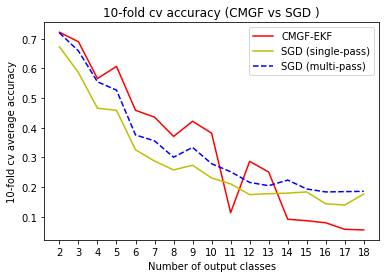

In [8]:
# Plot result
fig, ax = plt.subplots()
ax.plot(class_range, cmgf_accuracies, 'r', label='CMGF-EKF')
ax.plot(class_range, sgd_onepass_accuracies, 'y', label='SGD (single-pass)')
ax.plot(class_range, sgd_multipass_accuracies, 'b--', label='SGD (multi-pass)')
ax.set_xticks(class_range)
ax.set_xlabel('Number of output classes')
ax.set_ylabel(f'{n_splits}-fold cv average accuracy')
ax.set_title(f'{n_splits}-fold cv accuracy (CMGF vs SGD )')
ax.legend();

##3. Speed Comparison with SGD

In [9]:
data_size_grid = list(range(20, 100, 20)) + list(range(100, 1000, 100)) + list(range(1000, 10000, 1000)) \
                 + list(range(10000, 100000, 10000)) + list(range(100000, 1000000, 100000))

In [10]:
cmgf_est = CMGFEstimator()
sgd_op_est = SGDClassifier(loss='log_loss', max_iter=1)
sgd_mp_est = SGDClassifier(loss='log_loss')

# Plot timed results against different dataset sizes
# with fixed class size (K = 3)
import numpy as np
import time

cmgf_times, sgd_op_times, sgd_mp_times = [], [], []

it_times, vec_times = [], []
for data_size in data_size_grid:
    print(f'dataset of size {data_size}')
    simplefilter("ignore", category=ConvergenceWarning)
    input, output = make_classification(n_samples=data_size, n_features=4, n_informative=4, 
                                        n_redundant=0, n_classes=3, random_state=2)
    start = time.time()
    _ = cmgf_est.fit(input, output)
    cmgf_time = time.time() - start
    cmgf_times.append(cmgf_time)
    print(f'cmgf took {cmgf_time} seconds.')

    start = time.time()
    _ = sgd_op_est.fit(input, output)
    sgd_op_time = time.time() - start
    sgd_op_times.append(sgd_op_time)
    print(f'one-pass sgd took {sgd_op_time} seconds.')

    start = time.time()
    _ = sgd_mp_est.fit(input, output)
    sgd_mp_time = time.time() - start
    sgd_mp_times.append(sgd_mp_time)
    print(f'multi-pass sgd took {sgd_mp_time} seconds.')

dataset of size 20
cmgf took 0.7196810245513916 seconds.
one-pass sgd took 0.0025360584259033203 seconds.
multi-pass sgd took 0.0020117759704589844 seconds.
dataset of size 40
cmgf took 0.6449520587921143 seconds.
one-pass sgd took 0.0025148391723632812 seconds.
multi-pass sgd took 0.001699209213256836 seconds.
dataset of size 60
cmgf took 0.6478290557861328 seconds.
one-pass sgd took 0.002682924270629883 seconds.
multi-pass sgd took 0.0017039775848388672 seconds.
dataset of size 80
cmgf took 0.6472859382629395 seconds.
one-pass sgd took 0.00228118896484375 seconds.
multi-pass sgd took 0.0018758773803710938 seconds.
dataset of size 100
cmgf took 0.6280310153961182 seconds.
one-pass sgd took 0.002900838851928711 seconds.
multi-pass sgd took 0.0030431747436523438 seconds.
dataset of size 200
cmgf took 0.7257649898529053 seconds.
one-pass sgd took 0.002061128616333008 seconds.
multi-pass sgd took 0.007977962493896484 seconds.
dataset of size 300
cmgf took 1.1326961517333984 seconds.
one-p

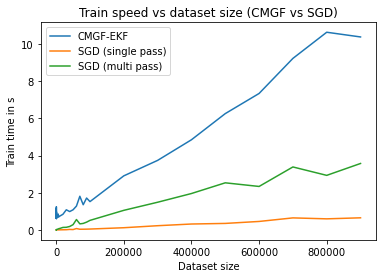

In [11]:
# Plot the result
fig, ax = plt.subplots()
ax.plot(data_size_grid, cmgf_times, label='CMGF-EKF')
ax.plot(data_size_grid, sgd_op_times, label='SGD (single pass)')
ax.plot(data_size_grid, sgd_mp_times, label='SGD (multi pass)')
ax.set_xlabel('Dataset size')
ax.set_ylabel('Train time in s')
ax.set_title('Train speed vs dataset size (CMGF vs SGD)')
ax.legend();
plt.show()

##4. (K-1) CMGF Binary Regressions

Let us try to construct the multinomial logistic regression as a combination of $(K-1)$ binary logistic regressions.

In [13]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [14]:
sigmoid_fn = lambda w, x: jax.nn.sigmoid(w @ x)

class CMGFOneVsAllEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self,  weights=None):
        self.weights = weights

    def fit(self, X, y):
        X_bias = jnp.concatenate([jnp.ones((len(X), 1)), X], axis=1)
        input_dim = X_bias.shape[-1]
        num_classes = y.max() + 1
        self.classes_ = jnp.arange(num_classes)

        # Construct CMGFParams
        cmgf_params = ParamsGGSSM(
            initial_mean = jnp.zeros(input_dim),
            initial_covariance = jnp.eye(input_dim),
            dynamics_function = lambda w, x: w,
            dynamics_covariance = jnp.zeros((input_dim, input_dim)),
            emission_mean_function = sigmoid_fn,
            emission_cov_function = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))
        )

        # Construct (K-1) binary classifiers
        classifiers = []
        for k in range(num_classes):
            y_k = jnp.array((y == k).astype(float))
            post = conditional_moments_gaussian_filter(cmgf_params, EKFIntegrals(), y_k, inputs=X_bias)
            classifiers.append(post.filtered_means[-1])

        self.weights = jnp.array(classifiers)
        return self
    
    def predict(self, X, y=None):
        X_bias = jnp.concatenate([jnp.ones((len(X), 1)), X], axis=1)
        return jnp.argmax(sigmoid_fn(X_bias, self.weights.T), axis=1)

Let's examine the speed-up.

In [15]:
cmgf_est = CMGFOneVsAllEstimator()
sgd_op_est = SGDClassifier(loss='log_loss', max_iter=1)
sgd_mp_est = SGDClassifier(loss='log_loss')

# Plot timed results against different dataset sizes
# with fixed class size (K = 3)
import numpy as np
import time

cmgf_times, sgd_op_times, sgd_mp_times = [], [], []

it_times, vec_times = [], []
for data_size in data_size_grid:
    print(f'dataset of size {data_size}')
    simplefilter("ignore", category=ConvergenceWarning)
    input, output = make_classification(n_samples=data_size, n_features=4, n_informative=4, 
                                        n_redundant=0, n_classes=3, random_state=2)
    start = time.time()
    _ = cmgf_est.fit(input, output)
    cmgf_time = time.time() - start
    cmgf_times.append(cmgf_time)
    print(f'cmgf took {cmgf_time} seconds.')

    start = time.time()
    _ = sgd_op_est.fit(input, output)
    sgd_op_time = time.time() - start
    sgd_op_times.append(sgd_op_time)
    print(f'one-pass sgd took {sgd_op_time} seconds.')

    start = time.time()
    _ = sgd_mp_est.fit(input, output)
    sgd_mp_time = time.time() - start
    sgd_mp_times.append(sgd_mp_time)
    print(f'multi-pass sgd took {sgd_mp_time} seconds.')

dataset of size 20
cmgf took 1.7440190315246582 seconds.
one-pass sgd took 0.00261688232421875 seconds.
multi-pass sgd took 0.0020270347595214844 seconds.
dataset of size 40
cmgf took 1.4410030841827393 seconds.
one-pass sgd took 0.0034291744232177734 seconds.
multi-pass sgd took 0.0019121170043945312 seconds.
dataset of size 60
cmgf took 1.3065917491912842 seconds.
one-pass sgd took 0.0030541419982910156 seconds.
multi-pass sgd took 0.0019769668579101562 seconds.
dataset of size 80
cmgf took 1.5565009117126465 seconds.
one-pass sgd took 0.0027031898498535156 seconds.
multi-pass sgd took 0.0018279552459716797 seconds.
dataset of size 100
cmgf took 1.227200984954834 seconds.
one-pass sgd took 0.002674102783203125 seconds.
multi-pass sgd took 0.002028942108154297 seconds.
dataset of size 200
cmgf took 1.1343879699707031 seconds.
one-pass sgd took 0.002565145492553711 seconds.
multi-pass sgd took 0.002866029739379883 seconds.
dataset of size 300
cmgf took 1.233407974243164 seconds.
one-pa

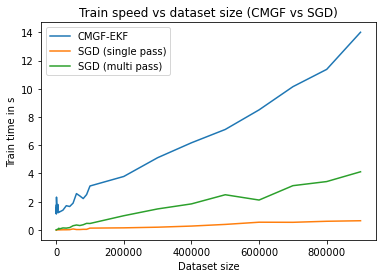

In [16]:
# Plot the result
fig, ax = plt.subplots()
ax.plot(data_size_grid, cmgf_times, label='CMGF-EKF')
ax.plot(data_size_grid, sgd_op_times, label='SGD (single pass)')
ax.plot(data_size_grid, sgd_mp_times, label='SGD (multi pass)')
ax.set_xlabel('Dataset size')
ax.set_ylabel('Train time in s')
ax.set_title('Train speed vs dataset size (CMGF vs SGD)')
ax.legend();
plt.show()

In [17]:
num_points = 1000
class_range = range(2, 19)
n_splits = 5

cmgf_accuracies, sgd_onepass_accuracies, sgd_multipass_accuracies = [], [], []
for num_classes in class_range:
    print(f'{num_points} data points, {num_classes} classes.')
    
    # Initialize estimators
    cmgf_est = CMGFOneVsAllEstimator()
    sgd_op_est = SGDClassifier(loss='log_loss', max_iter=1)
    sgd_mp_est = SGDClassifier(loss='log_loss')
    
    # Compute cv average scores
    cmgf_ac = compute_cv_avg_score(cmgf_est, num_points, num_classes, n_splits=n_splits)
    cmgf_accuracies.append(cmgf_ac)
    print(f'EKF-CMGF estimate average accuracy = {cmgf_ac}')
    sgd_op_ac = compute_cv_avg_score(sgd_op_est, num_points, num_classes, n_splits=n_splits)
    sgd_onepass_accuracies.append(sgd_op_ac)
    print(f'One-pass sgd estimate average accuracy = {sgd_op_ac}')
    sgd_mp_ac = compute_cv_avg_score(sgd_mp_est, num_points, num_classes, n_splits=n_splits)
    sgd_multipass_accuracies.append(sgd_mp_ac)
    print(f'Multi-pass sgd estimate average accuracy = {sgd_mp_ac}')

1000 data points, 2 classes.
EKF-CMGF estimate average accuracy = 0.7190000000000001
One-pass sgd estimate average accuracy = 0.675
Multi-pass sgd estimate average accuracy = 0.712
1000 data points, 3 classes.
EKF-CMGF estimate average accuracy = 0.69
One-pass sgd estimate average accuracy = 0.56
Multi-pass sgd estimate average accuracy = 0.6529999999999999
1000 data points, 4 classes.
EKF-CMGF estimate average accuracy = 0.557
One-pass sgd estimate average accuracy = 0.429
Multi-pass sgd estimate average accuracy = 0.514
1000 data points, 5 classes.
EKF-CMGF estimate average accuracy = 0.601
One-pass sgd estimate average accuracy = 0.44000000000000006
Multi-pass sgd estimate average accuracy = 0.551
1000 data points, 6 classes.
EKF-CMGF estimate average accuracy = 0.4640000000000001
One-pass sgd estimate average accuracy = 0.35
Multi-pass sgd estimate average accuracy = 0.38
1000 data points, 7 classes.
EKF-CMGF estimate average accuracy = 0.43299999999999994
One-pass sgd estimate ave

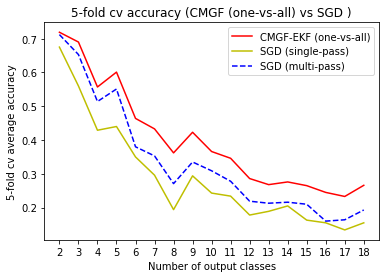

In [18]:
# Plot result
fig, ax = plt.subplots()
ax.plot(class_range, cmgf_accuracies, 'r', label='CMGF-EKF (one-vs-all)')
ax.plot(class_range, sgd_onepass_accuracies, 'y', label='SGD (single-pass)')
ax.plot(class_range, sgd_multipass_accuracies, 'b--', label='SGD (multi-pass)')
ax.set_xticks(class_range)
ax.set_xlabel('Number of output classes')
ax.set_ylabel(f'{n_splits}-fold cv average accuracy')
ax.set_title(f'{n_splits}-fold cv accuracy (CMGF (one-vs-all) vs SGD )')
ax.legend();

#5. Statistical and Computational Efficiency Comparison with SGD

We compare the [statistical and computational efficiencies](https://mc-stan.org/docs/2_22/stan-users-guide/statistical-vs-computational-efficiency.html) of CMGF with those of one-pass and multi-pass SGD.

We use 5-fold CV with `scoring='neg_log_loss'` to compute average log-likelihood score.

In [19]:
data_size_grid = list(range(20, 100, 20)) + list(range(100, 1000, 100)) + list(range(1000, 10000, 1000))

First, we try `num_classes=2`.

In [20]:
num_classes = 2
n_splits = 5

cmgf_logliks, sgd_onepass_logliks, sgd_multipass_logliks = [], [], []
cmgf_times, sgd_op_times, sgd_mp_times = [], [], []
simplefilter("ignore", category=ConvergenceWarning)

for num_points in data_size_grid:
    print(f'{num_points} data points, {num_classes} classes.')
    
    # Initialize estimators
    cmgf_est = CMGFEstimator()
    sgd_op_est = SGDClassifier(loss='log_loss', max_iter=1)
    sgd_mp_est = SGDClassifier(loss='log_loss')
    
    # Compute cv average scores
    start = time.time()
    cmgf_ll = compute_cv_avg_score(cmgf_est, num_points, num_classes, n_splits=n_splits, scoring='neg_log_loss')
    cmgf_time = time.time() - start
    cmgf_logliks.append(cmgf_ll)
    cmgf_times.append(cmgf_time)
    print(f'EKF-CMGF estimate average per-sample log-likelihood = {cmgf_ll}')
    print(f'cmgf took {cmgf_time} seconds.')

    start = time.time()
    sgd_op_ll = compute_cv_avg_score(sgd_op_est, num_points, num_classes, n_splits=n_splits, scoring='neg_log_loss')
    sgd_op_time = time.time() - start
    sgd_onepass_logliks.append(sgd_op_ll)
    sgd_op_times.append(sgd_op_time)
    print(f'One-pass sgd estimate average per-sample log-likelihood = {sgd_op_ll}')
    print(f'one-pass sgd took {sgd_op_time} seconds.')

    start = time.time()
    sgd_mp_ll = compute_cv_avg_score(sgd_mp_est, num_points, num_classes, n_splits=n_splits, scoring='neg_log_loss')
    sgd_mp_time = time.time() - start
    sgd_multipass_logliks.append(sgd_mp_ll)
    sgd_mp_times.append(sgd_mp_time)
    print(f'Multi-pass sgd estimate average per-sample log-likelihood = {sgd_mp_ll}')
    print(f'multi-pass sgd took {sgd_mp_time} seconds.')

20 data points, 2 classes.
EKF-CMGF estimate average per-sample log-likelihood = -0.7113923319434529
cmgf took 2.701817035675049 seconds.
One-pass sgd estimate average per-sample log-likelihood = -9.713762037331042
one-pass sgd took 0.02339482307434082 seconds.
Multi-pass sgd estimate average per-sample log-likelihood = -7.607823027835491
multi-pass sgd took 0.013565301895141602 seconds.
40 data points, 2 classes.
EKF-CMGF estimate average per-sample log-likelihood = -0.7182775438816396
cmgf took 2.558962106704712 seconds.
One-pass sgd estimate average per-sample log-likelihood = -10.326573788116002
one-pass sgd took 0.04997515678405762 seconds.
Multi-pass sgd estimate average per-sample log-likelihood = -4.8723470535631055
multi-pass sgd took 0.035867929458618164 seconds.
60 data points, 2 classes.
EKF-CMGF estimate average per-sample log-likelihood = -0.6552413701643471
cmgf took 2.700808048248291 seconds.
One-pass sgd estimate average per-sample log-likelihood = -5.515793678955641
o

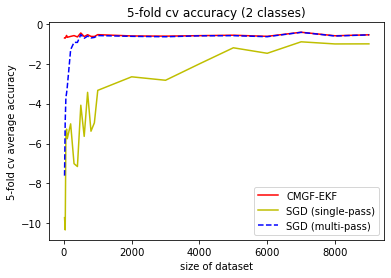

In [21]:
# Plot result
fig, ax = plt.subplots()
ax.plot(data_size_grid, cmgf_logliks, 'r', label='CMGF-EKF')
ax.plot(data_size_grid, sgd_onepass_logliks, 'y', label='SGD (single-pass)')
ax.plot(data_size_grid, sgd_multipass_logliks, 'b--', label='SGD (multi-pass)')
ax.set_xlabel('size of dataset')
ax.set_ylabel(f'{n_splits}-fold cv average accuracy')
ax.set_title(f'{n_splits}-fold cv accuracy ({num_classes} classes)')
ax.legend();

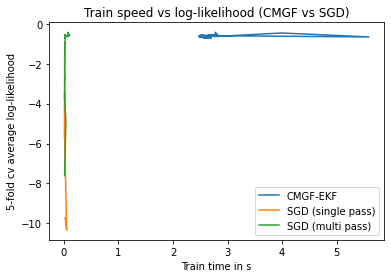

In [22]:
# Plot the result
fig, ax = plt.subplots()
ax.plot(cmgf_times, cmgf_logliks, label='CMGF-EKF')
ax.plot(sgd_op_times, sgd_onepass_logliks, label='SGD (single pass)')
ax.plot(sgd_mp_times, sgd_multipass_logliks, label='SGD (multi pass)')
ax.set_xlabel('Train time in s')
ax.set_ylabel(f'{n_splits}-fold cv average log-likelihood')
ax.set_title('Train speed vs log-likelihood (CMGF vs SGD)')
ax.legend();
plt.show()

Next, we try 4 classes

In [23]:
data_size_grid = list(range(60, 100, 20)) + list(range(100, 1000, 100)) + list(range(1000, 10000, 1000))

In [24]:
num_classes = 4
n_splits = 5

cmgf_logliks, sgd_onepass_logliks, sgd_multipass_logliks = [], [], []
simplefilter("ignore", category=ConvergenceWarning)
for num_points in data_size_grid:
    print(f'{num_points} data points, {num_classes} classes.')
    
    # Initialize estimators
    cmgf_est = CMGFEstimator()
    sgd_op_est = SGDClassifier(loss='log_loss', max_iter=1)
    sgd_mp_est = SGDClassifier(loss='log_loss')
    
    # Compute cv average scores
    cmgf_ll = compute_cv_avg_score(cmgf_est, num_points, num_classes, n_splits=n_splits, scoring='neg_log_loss')
    cmgf_logliks.append(cmgf_ll)
    print(f'EKF-CMGF estimate average per-sample log-likelihood = {cmgf_ll}')
    sgd_op_ll = compute_cv_avg_score(sgd_op_est, num_points, num_classes, n_splits=n_splits, scoring='neg_log_loss')
    sgd_onepass_logliks.append(sgd_op_ll)
    print(f'One-pass sgd estimate average per-sample log-likelihood = {sgd_op_ll}')
    sgd_mp_ll = compute_cv_avg_score(sgd_mp_est, num_points, num_classes, n_splits=n_splits, scoring='neg_log_loss')
    sgd_multipass_logliks.append(sgd_mp_ll)
    print(f'Multi-pass sgd estimate average per-sample log-likelihood = {sgd_mp_ll}')

60 data points, 4 classes.
EKF-CMGF estimate average per-sample log-likelihood = -1.3660175909293018
One-pass sgd estimate average per-sample log-likelihood = -10.778582284064314
Multi-pass sgd estimate average per-sample log-likelihood = -13.788886333174542
80 data points, 4 classes.
EKF-CMGF estimate average per-sample log-likelihood = -1.1990102869450185
One-pass sgd estimate average per-sample log-likelihood = -11.338344276608229
Multi-pass sgd estimate average per-sample log-likelihood = -9.21657726017058
100 data points, 4 classes.
EKF-CMGF estimate average per-sample log-likelihood = -1.1242199630520209
One-pass sgd estimate average per-sample log-likelihood = -14.632278422648
Multi-pass sgd estimate average per-sample log-likelihood = -5.894469698659815
200 data points, 4 classes.
EKF-CMGF estimate average per-sample log-likelihood = -1.076108481663493
One-pass sgd estimate average per-sample log-likelihood = -10.542790490494625
Multi-pass sgd estimate average per-sample log-li

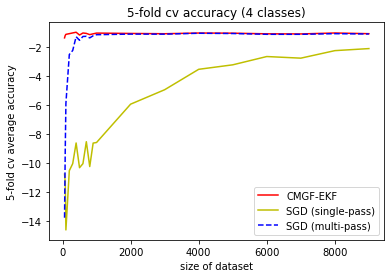

In [25]:
# Plot result
fig, ax = plt.subplots()
ax.plot(data_size_grid, cmgf_logliks, 'r', label='CMGF-EKF')
ax.plot(data_size_grid, sgd_onepass_logliks, 'y', label='SGD (single-pass)')
ax.plot(data_size_grid, sgd_multipass_logliks, 'b--', label='SGD (multi-pass)')
ax.set_xlabel('size of dataset')
ax.set_ylabel(f'{n_splits}-fold cv average accuracy')
ax.set_title(f'{n_splits}-fold cv accuracy ({num_classes} classes)')
ax.legend();

Finally, we try 10 classes.

In [26]:
data_size_grid = list(range(150, 1000, 100)) + list(range(1000, 10000, 1000))

In [28]:
num_classes = 10
n_splits = 5

cmgf_logliks, sgd_onepass_logliks, sgd_multipass_logliks = [], [], []
simplefilter("ignore", category=ConvergenceWarning)
for num_points in data_size_grid:
    print(f'{num_points} data points, {num_classes} classes.')
    
    # Initialize estimators
    cmgf_est = CMGFEstimator()
    sgd_op_est = SGDClassifier(loss='log_loss', max_iter=1)
    sgd_mp_est = SGDClassifier(loss='log_loss')
    
    # Compute cv average scores
    cmgf_ll = compute_cv_avg_score(cmgf_est, num_points, num_classes, n_splits=n_splits, scoring='neg_log_loss')
    cmgf_logliks.append(cmgf_ll)
    print(f'EKF-CMGF estimate average per-sample log-likelihood = {cmgf_ll}')
    sgd_op_ll = compute_cv_avg_score(sgd_op_est, num_points, num_classes, n_splits=n_splits, scoring='neg_log_loss')
    sgd_onepass_logliks.append(sgd_op_ll)
    print(f'One-pass sgd estimate average per-sample log-likelihood = {sgd_op_ll}')
    sgd_mp_ll = compute_cv_avg_score(sgd_mp_est, num_points, num_classes, n_splits=n_splits, scoring='neg_log_loss')
    sgd_multipass_logliks.append(sgd_mp_ll)
    print(f'Multi-pass sgd estimate average per-sample log-likelihood = {sgd_mp_ll}')

150 data points, 10 classes.
EKF-CMGF estimate average per-sample log-likelihood = -2.2024027226329665
One-pass sgd estimate average per-sample log-likelihood = -22.800085233124605
Multi-pass sgd estimate average per-sample log-likelihood = -12.865444661569914
250 data points, 10 classes.
EKF-CMGF estimate average per-sample log-likelihood = -2.4169931322986367
One-pass sgd estimate average per-sample log-likelihood = -22.05200472794619
Multi-pass sgd estimate average per-sample log-likelihood = -9.673732318635512
350 data points, 10 classes.
EKF-CMGF estimate average per-sample log-likelihood = -2.042712910334882
One-pass sgd estimate average per-sample log-likelihood = -21.33431155944107
Multi-pass sgd estimate average per-sample log-likelihood = -5.141729941222382
450 data points, 10 classes.
EKF-CMGF estimate average per-sample log-likelihood = -1.8853725642488697
One-pass sgd estimate average per-sample log-likelihood = -20.17853671920991
Multi-pass sgd estimate average per-sample

/Users/ghd/miniconda3/envs/pyprobml/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ghd/miniconda3/envs/pyprobml/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ghd/miniconda3/envs/pyprobml/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 107, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/ghd/miniconda3/envs/pyprobml/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 313, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/Users/ghd/miniconda3/envs/pyprobml/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 2587, in log_loss
    y_pred = check_array(
  File "/Users/g

EKF-CMGF estimate average per-sample log-likelihood = nan
One-pass sgd estimate average per-sample log-likelihood = -17.940825917272207
Multi-pass sgd estimate average per-sample log-likelihood = -2.035231772886369
3000 data points, 10 classes.
EKF-CMGF estimate average per-sample log-likelihood = -1.7888673913163289
One-pass sgd estimate average per-sample log-likelihood = -14.86164494405929
Multi-pass sgd estimate average per-sample log-likelihood = -1.955591383515685
4000 data points, 10 classes.
EKF-CMGF estimate average per-sample log-likelihood = -1.7710430093930547
One-pass sgd estimate average per-sample log-likelihood = -13.704490221626111
Multi-pass sgd estimate average per-sample log-likelihood = -1.8925902576807385
5000 data points, 10 classes.
EKF-CMGF estimate average per-sample log-likelihood = -1.7388310203656765
One-pass sgd estimate average per-sample log-likelihood = -10.97956073541048
Multi-pass sgd estimate average per-sample log-likelihood = -1.8247676601035188
60

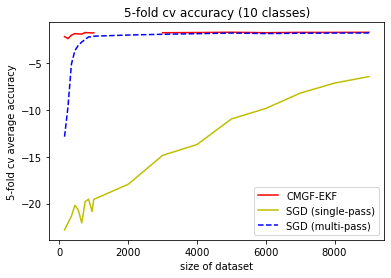

In [29]:
# Plot result
fig, ax = plt.subplots()
ax.plot(data_size_grid, cmgf_logliks, 'r', label='CMGF-EKF')
ax.plot(data_size_grid, sgd_onepass_logliks, 'y', label='SGD (single-pass)')
ax.plot(data_size_grid, sgd_multipass_logliks, 'b--', label='SGD (multi-pass)')
ax.set_xlabel('size of dataset')
ax.set_ylabel(f'{n_splits}-fold cv average accuracy')
ax.set_title(f'{n_splits}-fold cv accuracy ({num_classes} classes)')
ax.legend();